In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from sklearn import linear_model
from sklearn import ensemble

from sklearn import metrics

%matplotlib inline

In [2]:
# TRAIN_FILE = './data/tony-finau-round-course-train.csv'
# TEST_FILE = './data/tony-finau-round-course-test.csv'

TRAIN_FILE = './data/2015-2017-round-course-train.csv'
TEST_FILE = './data/2015-2017-round-course-test.csv'

In [3]:
def parse_teetime_hour(val):
    return val[0:val.find(':')]

def load_and_process_data(file):
    df = pd.read_csv(file, index_col=None)
    
    # Convert string fields (course data) to numeric
    label_encoder = LabelEncoder()
    df['CourseFairwayFirmness'] = label_encoder.fit_transform(df['CourseFairwayFirmness'])
    df['CourseGreenFirmness'] = label_encoder.fit_transform(df['CourseGreenFirmness'])
    df['CourseGreenGrass'] = label_encoder.fit_transform(df['CourseGreenGrass'])
    df['CourseFairwayGrass'] = label_encoder.fit_transform(df['CourseFairwayGrass'])
    df['CourseTeeGrass'] = label_encoder.fit_transform(df['CourseTeeGrass'])
    df['CourseRoughGrass'] = label_encoder.fit_transform(df['CourseRoughGrass'])

    # Convert TeeTime into just the hour
    df['TeeTime'] = df['TeeTime'].apply(parse_teetime_hour)
    
    # Convert -1 for no attempts to mean value??
    # imputer = preprocessing.Imputer(missing_values='-1', strategy='mean', axis=0)
    # imputer1 = imputer.fit_transform(df['Approach50-75'].values.reshape(-1,1))
    # df['Approach50-75'] = imputer1
    
    # Drop score related columns
    df.drop(
        columns=['ScoreEagles', 'ScoreBirdies', 'ScorePars', 'ScoreBogeys', 'ScoreDoubles', 'ScoreOthers', 'ScoreOverPar'],
        axis=1,
        inplace=True
    )
    
    # Drop strokes-gained related columns (calculated after the round)
    df.drop(
        columns=['SGPutting', 'SGTeeToGreen', 'SGTotal', 'SGOffTheTee', 'SGApproach', 'SGAroundTheGreen'],
        axis=1,
        inplace=True
    )
    
    # Drop end of round/event position
    df.drop(
        columns=['EndOfRoundFinishPosition', 'EndOfEventFinishPosition'],
        axis=1,
        inplace=True
    )
    
    return df

def split_data(df):
    # return X, y
    return df[df.columns[1:]], df[df.columns[0]]

In [4]:
df_train = load_and_process_data(TRAIN_FILE)
df_test = load_and_process_data(TEST_FILE)

In [5]:
print('Training Shape', df_train.shape)
print('Test Shape', df_test.shape)

Training Shape (47685, 97)
Test Shape (15896, 97)


In [6]:
X_train, y_train = split_data(df_train)
X_test, y_test = split_data(df_test)

print('Training X Shape', X_train.shape)
print('Training y Shape', y_train.shape)
print('Test X Shape', X_test.shape)
print('Test y Shape', y_test.shape)

Training X Shape (47685, 96)
Training y Shape (47685,)
Test X Shape (15896, 96)
Test y Shape (15896,)


In [7]:
def run_model(model):
    fit_time_start = time.clock()
    model.fit(X_train, y_train)
    fit_time_end = time.clock()
    
    pred_time_start = time.clock()
    y_pred = model.predict(X_test)
    pred_time_end = time.clock()
    
    fit_time_diff = fit_time_end - fit_time_start
    pred_time_diff = pred_time_end - pred_time_start
    print('Time to fit: {0:.2f} s'.format(fit_time_diff))
    print('Time to predict: {0:.2f} s'.format(pred_time_diff))
    
    #print('Coefficients: \n', model.coef_)
    
    return model, y_pred

def eval_model(y_true, y_pred):
    print('Explained Variance Score (higher == better): %.2f' % metrics.explained_variance_score(y_true, y_pred))
    print('Mean Absolute Error: %.2f' % metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error: %.2f' % metrics.mean_squared_error(y_true, y_pred))
    print('Mean Squared Log Error: %.2f' % metrics.mean_squared_log_error(y_true, y_pred))
    print('Median Absolute Error: %.2f' % metrics.median_absolute_error(y_true, y_pred))
    print('R2 Score (1.00 == perfect): %.2f' % metrics.r2_score(y_true, y_pred)) # 1 is perfect prediction

def plot_feature_importance(model):
    feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(num=None, figsize=(8, 20), dpi=80, facecolor='w', edgecolor='k')
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_test.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    plt.close()

def plot_training_deviance(model):
    test_score = np.zeros((model.n_estimators,), dtype=np.float64)

    for i, y_pred in enumerate(model.staged_predict(X_test)):
        test_score[i] = model.loss_(y_test, y_pred)

    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Deviance')
    plt.plot(np.arange(model.n_estimators) + 1, model.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(model.n_estimators) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')

In [8]:
model, pred = run_model(linear_model.LinearRegression())
eval_model(y_test, pred)

Time to fit: 0.38 s
Time to predict: 0.14 s
Explained Variance Score (higher == better): 0.89
Mean Absolute Error: 0.81
Mean Squared Error: 1.17
Mean Squared Log Error: 0.00
Median Absolute Error: 0.64
R2 Score (1.00 == perfect): 0.89


In [9]:
model, pred = run_model(linear_model.LogisticRegression())
eval_model(y_test, pred)

Time to fit: 352.68 s
Time to predict: 0.09 s
Explained Variance Score (higher == better): 0.47
Mean Absolute Error: 1.54
Mean Squared Error: 5.52
Mean Squared Log Error: 0.00
Median Absolute Error: 1.00
R2 Score (1.00 == perfect): 0.47


In [10]:
model, pred = run_model(linear_model.Ridge(alpha=0.5))
eval_model(y_test, pred)

Time to fit: 0.34 s
Time to predict: 0.09 s
Explained Variance Score (higher == better): 0.89
Mean Absolute Error: 0.81
Mean Squared Error: 1.17
Mean Squared Log Error: 0.00
Median Absolute Error: 0.64
R2 Score (1.00 == perfect): 0.89


In [11]:
model, pred = run_model(linear_model.Lasso(alpha=0.1, max_iter=10000))
eval_model(y_test, pred)

Time to fit: 7.14 s
Time to predict: 0.09 s
Explained Variance Score (higher == better): 0.83
Mean Absolute Error: 1.04
Mean Squared Error: 1.82
Mean Squared Log Error: 0.00
Median Absolute Error: 0.86
R2 Score (1.00 == perfect): 0.82


In [12]:
model, pred = run_model(linear_model.BayesianRidge())
eval_model(y_test, pred)

Time to fit: 0.48 s
Time to predict: 0.09 s
Explained Variance Score (higher == better): 0.89
Mean Absolute Error: 0.81
Mean Squared Error: 1.17
Mean Squared Log Error: 0.00
Median Absolute Error: 0.64
R2 Score (1.00 == perfect): 0.89


In [13]:
#model, pred = run_model(linear_model.ARDRegression(compute_score=True))
#eval_model(y_test, pred)

MemoryError: 

In [14]:
model, pred = run_model(ensemble.GradientBoostingRegressor(
    n_estimators=500,
    max_depth=4,
    min_samples_split=2,
    learning_rate=0.01,
    loss='ls'))
eval_model(y_test, pred)

Time to fit: 129.35 s
Time to predict: 0.44 s
Explained Variance Score (higher == better): 0.89
Mean Absolute Error: 0.81
Mean Squared Error: 1.15
Mean Squared Log Error: 0.00
Median Absolute Error: 0.65
R2 Score (1.00 == perfect): 0.89


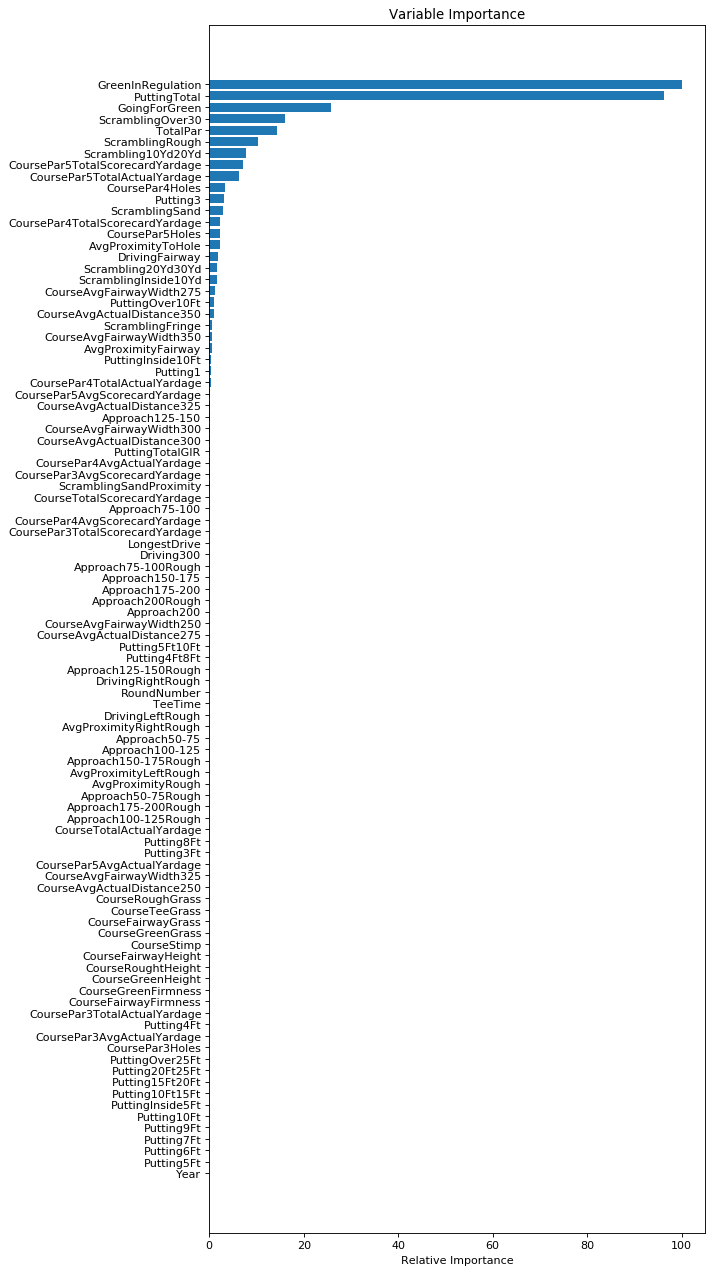

In [15]:
plot_feature_importance(model)

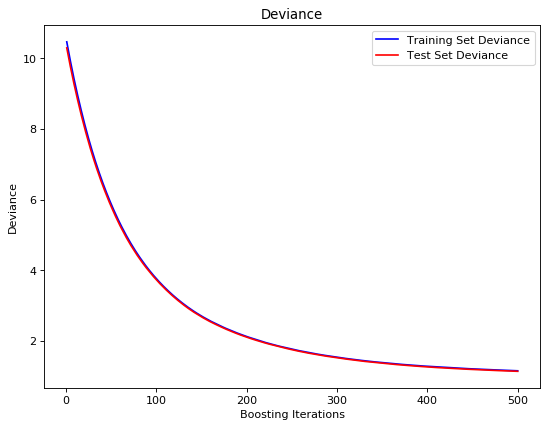

In [16]:
plot_training_deviance(model)

In [17]:
sample_idx = list(X_test.sample(n=5).index)

for i in sample_idx:
    print('Actual Score:', y_test.iloc[i], 
          'Predicted Score:', int(round(pred[i], 0)), 
          'Difference:', int(y_test.iloc[i]) - int(round(pred[i], 0)),
          'Index:', i)

Actual Score: 67 Predicted Score: 68 Difference: -1 Index: 15643
Actual Score: 70 Predicted Score: 70 Difference: 0 Index: 7034
Actual Score: 63 Predicted Score: 65 Difference: -2 Index: 15672
Actual Score: 68 Predicted Score: 69 Difference: -1 Index: 11102
Actual Score: 70 Predicted Score: 72 Difference: -2 Index: 13377
